In [6]:
import copy
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import diags, csr_matrix

In [7]:
s = 2
r = 0.045
rho = 0.05
w =0.1

I = 500
amin = -0.02
amax = 1
a = np.linspace(amin,amax,I)
da = (amax-amin)/(I-1)


crit = 10^(-9)

dVf = np.zeros((I,))
dVb = np.zeros((I,))
c = np.zeros((I,))

#INITIAL GUESS
v0 = (0.2 + r*a)**(1-s)/(1-s)/rho
v = v0


maxit=20000
Delta = 0.1
crit = 10**(-5)
dist=np.ones(maxit)

In [8]:

# Semi-implicit long time convergene
for n in range(maxit):
    V = copy.deepcopy(v)
    ## forward difference method eq.(8)
    dVf[0:I-1] = (V[1:I]-V[0:I-1])/da
    dVf[I-1] = 1 ## never be used, but set 1 make sure there is no exception
    ## backward difference method eq.(8)
    dVb[1:I] = (V[1:I]-V[0:I-1])/da
    dVb[0] = (w+r*amin)**(-s)
    ## consumption and savings with forward difference     u=x^(1-s)/1-s  => (u')^-1: x^(-1/s) 
    cf = dVf**(-1/s)
    sf = w + r*a - cf
    ## consumption and savings with backward difference
    cb = dVb**(-1/s)
    sb = w + r*a - cb
    ## consumption and derivative of value function at steady state
    c0 = w + r*a
    dV0 = c0**(-s)
    ## the indicator of upwind scheme 
    If = np.where(sf>0, 1, 0)
    Ib = np.where(sb<0, 1, 0)
    I0 = (1-If-Ib)     ## sijF<0<sijB
    dV_Upwind = dVf*If + dVb*Ib + dV0*I0
    ## compute c and u
    c = dV_Upwind**(-1/s)
    u = c**(1-s)/(1-s)
    ## CONSTRUCT MATRIX
    X = -np.minimum(sb,0)/da
    Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
    Z = np.maximum(sf,0)/da
    A = scipy.sparse.spdiags(Y[:],0,I,I)+scipy.sparse.spdiags(X[1:],-1,I,I)+scipy.sparse.spdiags(np.concatenate([np.array([0]),Z[:]]),1,I,I)
    B = (rho + 1/Delta)*scipy.sparse.eye(I) - A
    b = u + V/Delta
    V = scipy.sparse.linalg.spsolve(B, b)
    Vchange = V - v
    v=copy.deepcopy(V)
    dist[n] = np.max(np.abs(Vchange))
    if dist[n] < crit:
        print("Value function is converged. Iteration is:", n)
        break
    

Value function is converged. Iteration is: 2172


In [9]:
S = w + r*a - c

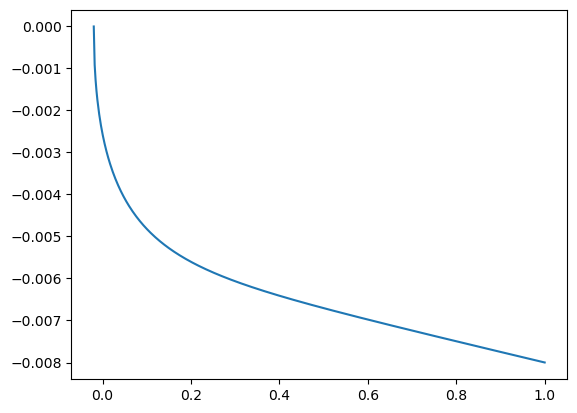

In [10]:
import matplotlib.pyplot as plt
plt.plot(a, S)

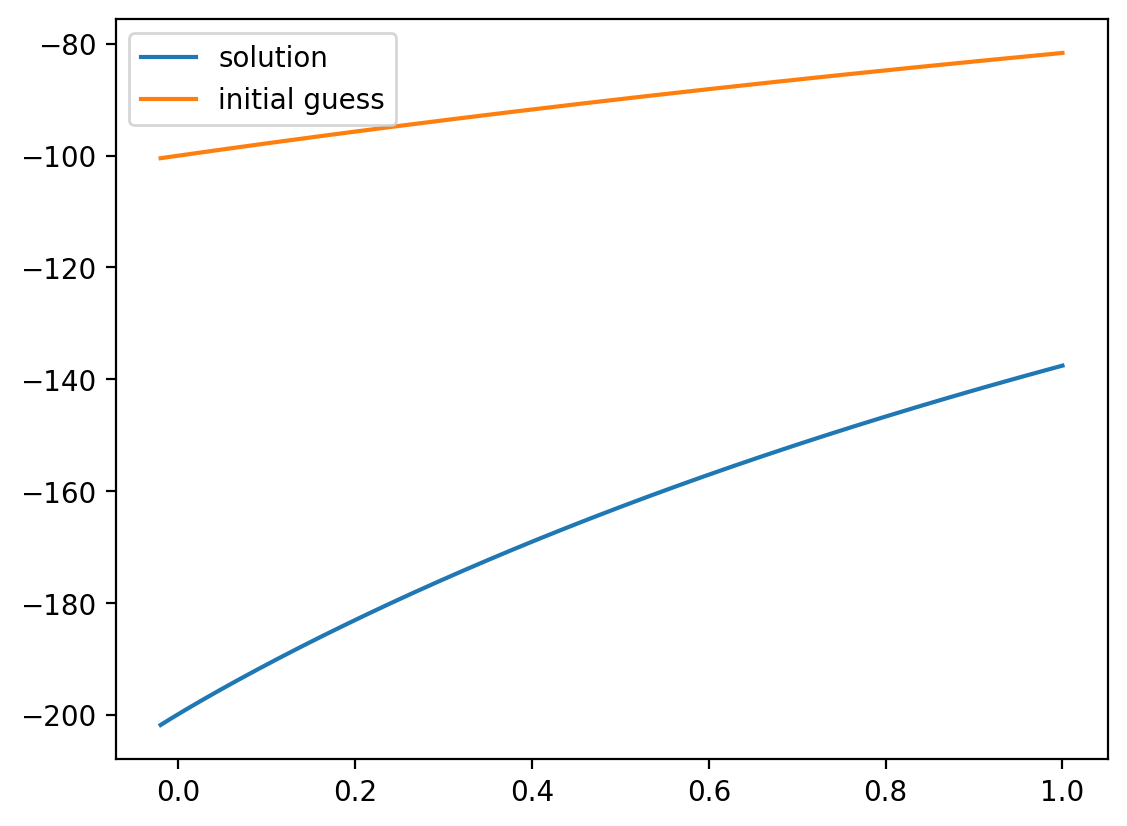

In [11]:
plt.figure(dpi=200)
plt.plot(a, v,label='solution')
plt.plot(a, v0,label='initial guess')
plt.legend()

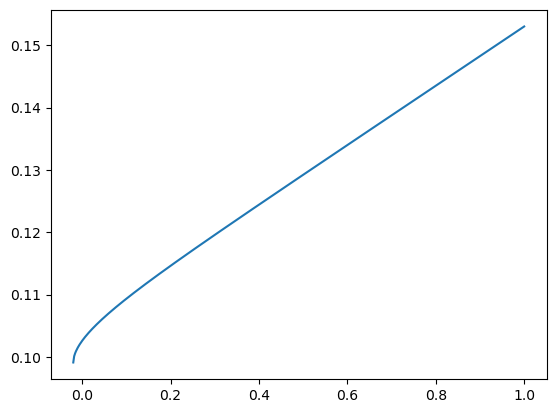

In [12]:
plt.plot(a, c)

In [45]:
# Policy iteration (Howard algorithm) setting up initial guess
c=0.5*a+2
cf=0.5*a+2
cb=0.5*a+2
sf = w + r*a - cf
sb = w + r*a - cb
# c=1*a
# cf=1*a
# cb=1*a
u = c**(1-s)/(1-s)

In [46]:
# Policy iteration (Howard algorithm)
V = np.zeros((I,))
plt.figure(1,dpi=200)
for n in range(maxit):
    ## the indicator of upwind scheme 
    ## CONSTRUCT MATRIX
    X = -np.minimum(sb,0)/da
    Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
    Z = np.maximum(sf,0)/da
    A = scipy.sparse.spdiags(Y[:]-rho,0,I,I)+scipy.sparse.spdiags(X[1:],-1,I,I)\
        +scipy.sparse.spdiags(np.concatenate([np.array([0]),Z[:]]),1,I,I)
    B =-A
    B = csr_matrix(B)
    b = u 
    V_new = scipy.sparse.linalg.spsolve(B, b)
    Vchange = V_new - V
    dist[n] = np.max(np.abs(Vchange))
    if dist[n] < 10**(-9):
        print("Value function is converged. Iteration is:", n)
        break
    V=V_new
    n=n+1
    dVf[0:I-1] = (V[1:I]-V[0:I-1])/da
    dVf[I-1] = 1 ## never be used, but set 1 make sure there is no exception
    ## backward difference method eq.(8)
    dVb[1:I] = (V[1:I]-V[0:I-1])/da
    dVb[0] = (w+r*amin)**(-s)
    cf = (np.abs(dVf))**(-1/s)
    # sf = w + r*a - cf
    ## consumption and savings with backward difference
    cb = (np.abs(dVb))**(-1/s)
    # sb = w + r*a - cb
    ## consumption and derivative of value function at steady state
    c0 = w + r*a
    dV0 = c0**(-s)
    sf = w + r*a - cf
    sb = w + r*a - cb
    If = np.where(sf>0, 1, 0)
    Ib = np.where(sb<0, 1, 0)
    I0 = (1-If-Ib)     ## sijF<0<sijB
    dV_Upwind = dVf*If + dVb*Ib + dV0*I0
    ## compute c and u
    c = (np.abs(dV_Upwind))**(-1/s)
    u = c**(1-s)/(1-s)
    print(np.max(Vchange))

    # if n%1 == 0:
    #     plt.plot(a, V, label='%.f'%n)
    #     plt.legend()
    #     plt.xlabel('a')    

-0.0005431934377030849
-196.90919736679865
17.15618454132786
24.35337652664785
16.776797242576095
4.1972816330261935
0.8672386559119616
0.3017644537479214
0.07448982344982369
0.023770029559273098
0.018706616911458696
0.027864173662663916
0.03425391248927667
0.044697718765718264
0.05306706369606218
0.06022915632428294
0.073503976001831
0.07755916326280499
0.07878753900232027
0.07800260623653799
0.08458557127184463
0.08089989148544419
0.08449750850107307
0.08483534924474156
0.08516094070714075
0.08544379137086366
0.08539224307415338
0.08610373131142524
0.08570334073559138
0.0861427007841371
0.08615262793929901
0.08623591763455352
0.08631557748898899
0.08635206622187752
0.08646834271578996
0.08647129066773118
0.08656655694059623
0.08660843042505917
0.08666610828251464
0.08672175928160186
0.08677226992369924
0.08683209767900735
0.08687911762746126
0.08693736075196057
0.08698833821617313
0.08704223634737218
0.08709546840702842
0.08714813430481172
0.08720198605664109
0.08725419734997786
0.08

<Figure size 1280x960 with 0 Axes>

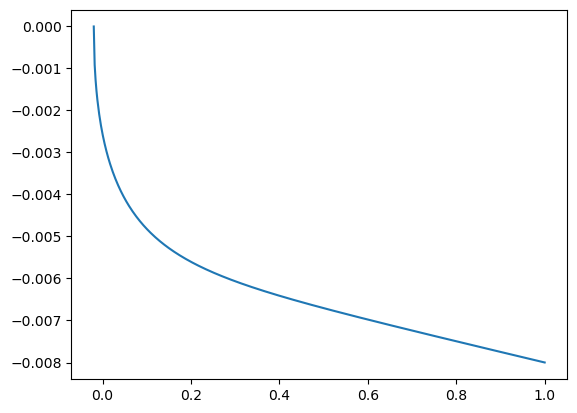

In [47]:
S = w + r*a - c
import matplotlib.pyplot as plt
plt.plot(a,  w + r*a - c)

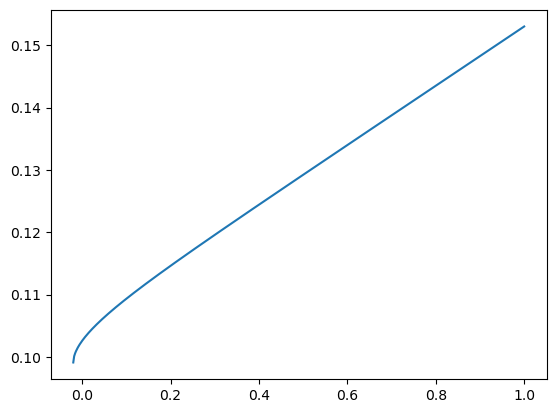

In [48]:
plt.plot(a,c)